## Importing relevant modules

In [1]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt


## Importing Dataset

In [2]:
train_dir = r"E:\Abhyaas\SEM VIII\BIO402 (Lab Project)\Skin cancer_Binary Classification\Skin cancer dataset\train"
test_dir = r"E:\Abhyaas\SEM VIII\BIO402 (Lab Project)\Skin cancer_Binary Classification\Skin cancer dataset\test"

In [3]:
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_test = sum([len(files) for r, d, files in os.walk(test_dir)])

In [4]:
print(total_train)
print(total_test)

2078
660


In [5]:
batch_size = 64
IMG_HEIGHT = 224
IMG_WIDTH = 224

## Preparing the dataset for the model and using data augmenting for smaller dataset size

In [6]:
train_image_generator = ImageDataGenerator(rescale= 1./255,
                                           horizontal_flip= True,
                                           zoom_range = 0.3,
                                           rotation_range = 15.,
                                           validation_split= 0.2,
                                          )
test_image_generator = ImageDataGenerator(rescale=1./255,
                                         )

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical',
                                                           classes = ('malignant', 'benign'),
                                                           subset='training'
                                                           )
val_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                         directory=train_dir,
                                                         target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                         class_mode='categorical',
                                                         classes = ('malignant', 'benign'),
                                                         subset='validation'
                                                        )

test_data_gen = test_image_generator.flow_from_directory(batch_size=1, 
                                                         directory=test_dir,
                                                         target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                         class_mode=None,
                                                         shuffle = False,
                                                         classes = ('malignant', 'benign')
                                                        )

Found 1662 images belonging to 2 classes.
Found 415 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


## Taking a look at the dataset

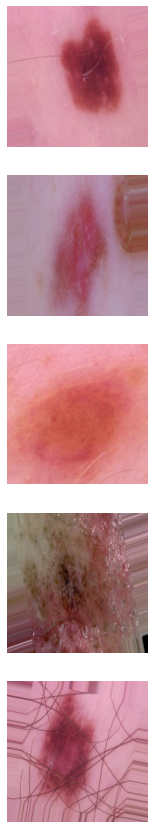

In [7]:
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% malignant")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% benign")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [8]:
def plot_history(history, yrange):
    '''Plot loss and accuracy as a function of the epoch,
    for the training and validation datasets.
    '''
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and validation accuracy')
    plt.ylim(yrange)
    
    # Plot training and validation loss per epoch
    plt.figure()

    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Training and validation loss')
    
    plt.show()

## Calling the pretrained model

In [9]:
base_pretrained_model = tf.keras.applications.VGG16(weights='imagenet', 
                   include_top = False,
                   input_shape = (224,224,3)
                  )

base_pretrained_model.trainable = False
base_pretrained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Adding the attention model

In [12]:
from tensorflow.keras import layers, models

in_lay = tf.keras.layers.Input(shape = (224, 224, 3))
pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]
pt_features = base_pretrained_model(in_lay)
bn_features = tf.keras.layers.BatchNormalization()(pt_features)

attn_layer = tf.keras.layers.Conv2D(64, 
                                    kernel_size = (1,1),
                                    padding = 'same', 
                                    activation = 'relu')(bn_features)
attn_layer = tf.keras.layers.Conv2D(16, 
                                      kernel_size = (1,1), 
                                      padding = 'same', 
                                      activation = 'relu')(attn_layer)
attn_layer = tf.keras.layers.Conv2D(1, 
                                      kernel_size = (1,1), 
                                      padding = 'valid', 
                                      activation = 'sigmoid')(attn_layer)

# fan it out to all of the channels
up_c2_w = np.ones((1, 1, 1, pt_depth))
up_c2 = tf.keras.layers.Conv2D(pt_depth, 
                               kernel_size = (1,1), 
                               padding = 'same', 
                               activation = 'linear', 
                               use_bias = False, 
                               weights = [up_c2_w])
up_c2.trainable = False
attn_layer_3 = up_c2(attn_layer)

mask_features = tf.keras.layers.multiply([attn_layer_3, bn_features])
gap_features = tf.keras.layers.GlobalAveragePooling2D()(mask_features)
gap_mask = tf.keras.layers.GlobalAveragePooling2D()(attn_layer_3)
# to account for missing values from the attention model
gap = tf.keras.layers.Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
gap_dr = tf.keras.layers.Dropout(0.5)(gap)
dr_steps = tf.keras.layers.Dropout(0.25)(Dense(128, activation = 'elu')(gap_dr))
u = tf.keras.layers.Dense(4096, 
                          activation='relu')(dr_steps)
y = tf.keras.layers.Dense(1072, 
                          activation='relu')(u)
out_layer = tf.keras.layers.Dense(2, activation = 'softmax')(y)

sc_model = tf.keras.Model(inputs = [in_lay], outputs = [out_layer])

## Compiling the model

In [13]:
sc_model.compile(tf.keras.optimizers.Adamax(learning_rate = 0.001), 
                 loss = tf.keras.losses.CategoricalCrossentropy(),
                 metrics = ['accuracy'])


In [24]:
sc_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, 7, 7, 512)    14714688    ['input_4[0][0]']                
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 7, 7, 512)   2048        ['vgg16[1][0]']                  
 rmalization)                                                                                     
                                                                                              

## Training the model

In [15]:
cp = tf.keras.callbacks.ModelCheckpoint('vgg16_1.h5',
                                        monitor = 'val_accuracy',
                                        save_best_only=True,
                                        verbose=1
                                       )

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'accuracy',
                                                  mode = 'max',
                                                  patience = 8
                                                 )

history = sc_model.fit(train_data_gen, 
                       validation_data = val_data_gen, 
                       epochs = 50, 
                       callbacks = [cp, early_stopping]
                      )


Epoch 1/50
26/26 [==============================] - ETA: 0s - loss: 0.5220 - accuracy: 0.7467
Epoch 1: val_accuracy improved from -inf to 0.45060, saving model to vgg16_1.h5
26/26 [==============================] - 78s 2s/step - loss: 0.5220 - accuracy: 0.7467 - val_loss: 0.7321 - val_accuracy: 0.4506
Epoch 2/50
26/26 [==============================] - ETA: 0s - loss: 0.4201 - accuracy: 0.8032
Epoch 2: val_accuracy improved from 0.45060 to 0.46988, saving model to vgg16_1.h5
26/26 [==============================] - 24s 920ms/step - loss: 0.4201 - accuracy: 0.8032 - val_loss: 0.6912 - val_accuracy: 0.4699
Epoch 3/50
26/26 [==============================] - ETA: 0s - loss: 0.4064 - accuracy: 0.8057
Epoch 3: val_accuracy improved from 0.46988 to 0.47229, saving model to vgg16_1.h5
26/26 [==============================] - 26s 980ms/step - loss: 0.4064 - accuracy: 0.8057 - val_loss: 0.6558 - val_accuracy: 0.4723
Epoch 4/50
26/26 [==============================] - ETA: 0s - loss: 0.3947 - ac

## Visualizing the training

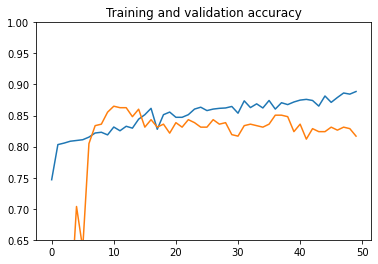

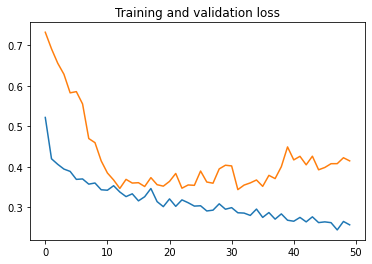

In [16]:
plot_history(history, (0.65, 1)) 

## Predicitons

[[0.00280438 0.9971956 ]]
Malignant with probability 99.71956014633179. Damn.


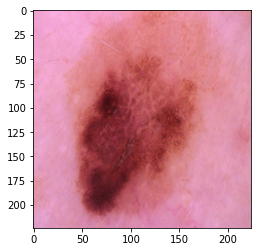

In [35]:
from keras.preprocessing import image
from keras.models import load_model
#saved_model = load_model("E:\Abhyaas\SEM VIII\BIO402 (Lab Project)\Skin cancer_Binary Classification\VGG_Skin_Classifier.h5")

img = image.load_img(r"E:\Abhyaas\SEM VIII\BIO402 (Lab Project)\Skin cancer_Binary Classification\Skin cancer dataset\test\malignant\1215.jpg", target_size=(224, 224))
x = image.img_to_array(img)
x = x / 255
x = np.expand_dims(x, axis=0)
plt.imshow(img)
classes = sc_model.predict(x)
print(classes)
if classes[0][0] >= 0.5:
    print("Beningn " + "with probability " + str(classes[0][0]*100) + ". You're safe (probably).")
else:
    print("Malignant " + "with probability " + str(classes[0][1]*100) + ". Damn.")

## Saving and pre-loading

In [21]:
sc_model.save('E:\Abhyaas\SEM VIII\BIO402 (Lab Project)\Skin cancer_Binary Classification\Attn')

INFO:tensorflow:Assets written to: E:\Abhyaas\SEM VIII\BIO402 (Lab Project)\Skin cancer_Binary Classification\Attn\assets


In [16]:
pred = sc_model.predict(test_data_gen, verbose = True)
predictedClasses = np.where(pred>0.5, 1, 0)
predY = np.argmax(pred, axis=1)


660/660 [==============================] - 18s 16ms/step


In [8]:
sc_model = tf.keras.models.load_model(r"E:\Abhyaas\SEM VIII\BIO402 (Lab Project)\Skin cancer_Binary Classification\Attn")

In [10]:
sc_model.evaluate(val_data_gen)

7/7 [==============================] - 7s 931ms/step - loss: 0.3803 - accuracy: 0.8410


[0.3803245723247528, 0.8409638404846191]

## Using confusion matrix to visualize model performance

              precision    recall  f1-score   support

      Benign       0.82      0.79      0.80       300
   Malignant       0.83      0.86      0.84       360

    accuracy                           0.83       660
   macro avg       0.83      0.82      0.82       660
weighted avg       0.83      0.83      0.83       660



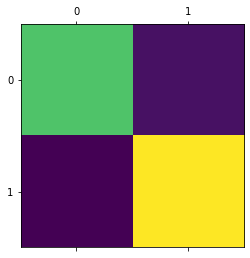

In [28]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
plt.matshow(confusion_matrix(test_data_gen.classes, predY>0.5))
print(classification_report(test_data_gen.classes, predY>0.5, target_names = ['Benign', 'Malignant']))

In [21]:
from sklearn import metrics

[[237  63]
 [ 52 308]]


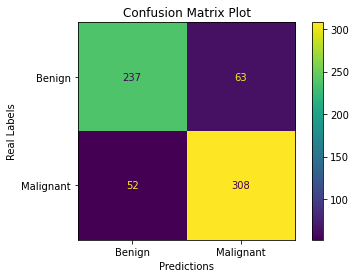

In [32]:
cm = confusion_matrix(test_data_gen.classes, predY>0.5)
## Print the Confusion Matrix.
print(cm)
## Create the Confusion Matrix Display Object(cmd_obj). Note the 
## alphabetical sorting order of the labels.
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['Benign', 'Malignant'])
## The plot() function has to be called for the sklearn visualization
## code to do its work and the Axes object to be created.
cmd_obj.plot()
## Use the Axes attribute 'ax_' to get to the underlying Axes object.
## The Axes object controls the labels for the X and the Y axes. It
## also controls the title.
cmd_obj.ax_.set(
                title='Confusion Matrix Plot', 
                xlabel='Predictions', 
                ylabel='Real Labels')
## Finally, call the matplotlib show() function to display the visualization
## of the Confusion Matrix.
plt.show()